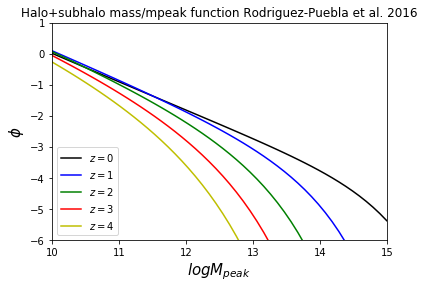

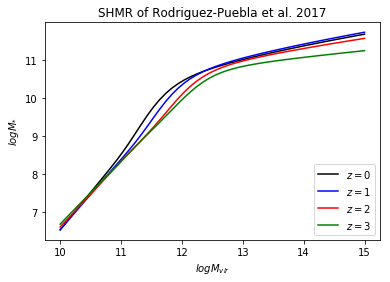

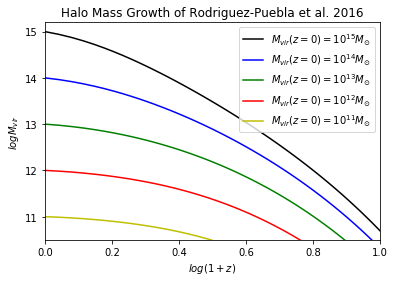

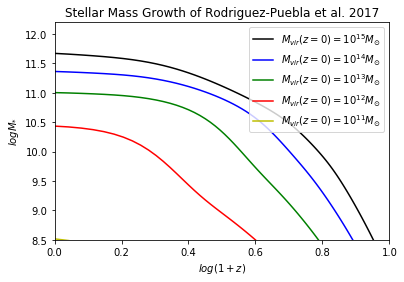

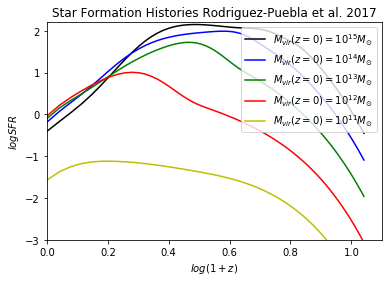

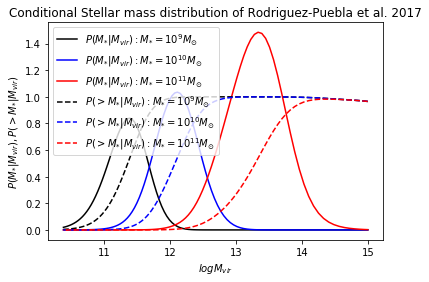

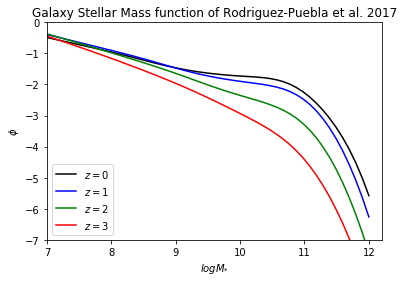

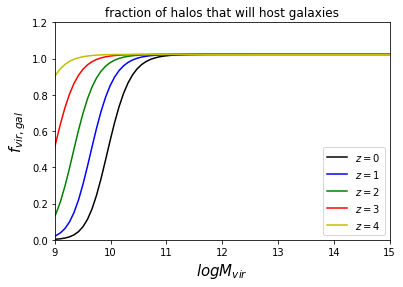

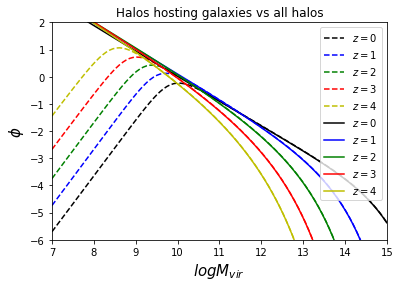

In [2]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import quad, nquad
from scipy import special
from scipy import optimize
import math

############################Constants##########################
G = 4.299E-9    #Gravitational constant Mpc Msol**-1 (km/s)**2

H0 = 100        #Today's Hubble constant km/s/Mpc

Myr = 1E6

#############Bolshoi-Planck Cosmological paramters##############
Om_mat_cero = 0.307

Om_lambda_cero = 0.693

Om_baryons = 0.048

sigma8  =  0.829

h  =  0.678

#####################Cosmology##########################
def Om_m(Om_mat,Om_lambda,z):        #Omega Matter
    return Om_mat * ( 1. + z )**3/( Om_lambda + Om_mat * ( 1. + z )**3 )

def Om_l(Om_mat,Om_lambda,z):        #Omega lambda
    return Om_lambda / ( Om_lambda + Om_mat * ( 1. + z )**3 )

def H(Om_mat,Om_lambda,z):
    return H0 * np.sqrt( Om_lambda + Om_mat * ( 1. + z )**3 )    #Hubble constant km/s/Mpc

def rho_crit(Om_mat,Om_lambda,z):
    return 3 * H(Om_mat,Om_lambda,z)**2 / 8 / math.pi /G    #Critical density M_sun / Mpc**3

def rho_m(Om_mat,Om_lambda,z):
    return Om_m(Om_mat,Om_lambda,z)*rho_crit(Om_mat,Om_lambda,z)

def t_age(Om_mat,Om_lambda,z):								#Age of Universe in yrs

    term1=2./ np.sqrt(Om_lambda) / 3. / H(Om_mat,Om_lambda,0.) / 1.02E-12 / h
    
    term2 = np.sqrt(Om_lambda*( 1. + z )**(-3.) )

    term3 = np.sqrt( Om_lambda*( 1. + z )**(-3.) + Om_mat )
        
    return	term1 * np.log ( ( term2 + term3 ) / np.sqrt( Om_mat_cero ) )

def DtDz(Om_mat,Om_lambda,z):   #dT_age / dz

    dz = 0.01
    
    dt = t_age(Om_mat,Om_lambda,z) - t_age(Om_mat,Om_lambda,dz + z)
    
    return dt/dz
def DZ(z,DT): #calculates the redshift z+dz given an interval of time DT and z. DT input is in Myrs

    def Delta_T(z_dz,DT,z):
        
        DT_age = t_age(Om_mat_cero,Om_lambda_cero,z) - t_age(Om_mat_cero,Om_lambda_cero,z_dz)

        return DT - DT_age / 1E6

    z_f = optimize.bisect(Delta_T, 0, 1000, args=(DT,z))

    return z_f

###################Halo and subhalo mass function#######################
def MF_h(Mvir,z):    #HMF from RP2016, Bolshoi-Planck paper. 1 / Mpc**3 / Msun

    def nu(nu_0, m_nu, m_nu2, z):
        
        return nu_0 + m_nu * z + m_nu2 * z * z
    
    def AT(z):
        
        return nu(0.143873,-0.0112026,0.00253025,z)

    def at(z):
        
        return nu(1.35053,0.0681399,-0.00593122,z)
    
    def bt(z):
        
        return nu(3.11271,-0.0770555,-0.0134007,z)
    
    def ct(z):
        
        return nu(1.1869,0.00875954,-0.000739608,z)
    
    def sigma(Mvir):    #RMS power spectrum Bolshoi-Planck, fit from RP2016
        
        y = 1E12 / Mvir
        
        term1 = 17.967209 * y**(0.409964)
        
        term2 = 1. + 1.179455 * y**(0.210397)+6.192103 * y**(0.320073)
        
        return term1 / term2
    
    def Dsigma_DM (Mvir):
        
        dlnsigma = np.log( 1./ sigma(1.002*Mvir ) ) - np.log( 1. / sigma(0.998*Mvir) )
        
        dlnMvir = np.log( 1.002 * Mvir ) - np.log( 0.998 * Mvir )
        
        return dlnsigma / dlnMvir
    
    def g_factor(Om_mat,Om_lambda,z):
        return Om_mat / ( 1. + z ) / (  Om_mat**(0.571428571) - Om_lambda + ( 1. + Om_mat * 0.5 ) * ( 1. + Om_lambda *0.014285714 ) )
    
    def D_growth_factor(Om_mat,Om_lambda,z):
        
        return g_factor(Om_mat,Om_lambda,z)/g_factor(Om_mat,Om_lambda,0.)
    
    d_growth = D_growth_factor(Om_mat_cero,Om_lambda_cero,z)
    
    sigma_z = d_growth * sigma(Mvir)

    f_nu = AT(z)* ( ( sigma_z / bt(z) )**( -at(z) ) + 1. ) * np.exp( -ct(z) / sigma_z / sigma_z)

    return f_nu * ( rho_crit(Om_mat_cero,Om_lambda_cero,0.) / Mvir**2) * Dsigma_DM(Mvir)

def MF_sub_peak(Mpeak,z): #subHMF for Mpeak from RP2016, Bolshoi-Planck paper. 1 / Mpc**3 / Msun

    def Csub(z):
        
        z2 = z * z

        return -0.086272 + 0.008670 * z - 0.011330 * z2 - 0.003892 * z2 * z + 0.000370 * z2 * z2

    def M_cut_off(z):
        
        z2 = z * z
        
        return 11.904572 - 0.636422 *z - 0.020686 * z2 + 0.022034 * z * z2 - 0.001151 * z2 * z2

    ratio = np.log10(Mpeak) - M_cut_off(z)

    MF_subhalos = Csub(z) + 0.072360 * ratio -  10**( 0.220586 * ratio ) * np.log10(np.exp(1.))

    MF_subhalos =  10**( MF_subhalos ) * MF_h(Mpeak,z)

    return MF_subhalos

def MF_peak(log10Mpeak,z): #HMF+subHMF. Mpeak = Mvir for distinct halos and Mpeak for subhalos. 1 / Mpc**3  / dex

    Mpeak = 10**( log10Mpeak + np.log10(h) ) #I'm using the value of h, note that in the in the simulation everything is in units of h.

    return ( MF_h(Mpeak,z) + MF_sub_peak(Mpeak,z) ) * Mpeak * h**3 / np.log10(np.exp(1.))

###################Stellar-to-Halo Mass Relations#######################
def SHMR_func( alpha, delta, gamma, log10eps, log10M1, log10Mvir):  #SHMR functional form; Behroozi+2010
    
    def g(x, a, g, d):
        
        return (-np.log10(10**(-a*x)+1.) +
                d*(np.log10(1.+np.exp(x)))**g/(1.+np.exp(10**(-x))))
    
    x = log10Mvir - log10M1
    
    g1 = g(x, alpha, gamma, delta)
    
    g0 = g(0, alpha, gamma, delta)
    
    log10Ms = log10eps + log10M1 + g1 - g0
    
    return log10Ms

def SHMR_RP17(z, log10Mvir):  #Best fitting model for the SHMR RP17.
    
    def P(x, y, z):
        return y*z - x*z/(1+z)
    
    def Q(z):
        return np.exp(-4/(1.+z)**2)
    
    al = (1.975, 0.714, 0.042)
    de = (3.390, -0.472, -0.931)
    ga = (0.498, -0.157)
    ep = (-1.758, 0.110, -0.061, -0.023)
    M0 = (11.548, -1.297, -0.026)
    
    alpha = al[0] + P(al[1], al[2], z) * Q(z)
    
    delta = de[0] + P(de[1], de[2], z) * Q(z)
    
    gamma = ga[0] + P(ga[1], 0, z) * Q(z)
    
    log10eps = ep[0] + P(ep[1], ep[2], z)*Q(z) + P(ep[3], 0, z)
    
    log10M1 = M0[0] + P(M0[1], M0[2], z)*Q(z)
    
    log10Ms = SHMR_func(alpha,delta,gamma,log10eps,log10M1,log10Mvir)
    
    return log10Ms

def f_int(log10Mvir,z): #Instantaneous fraction of stellar mass from Mergers (all type of mergers) Ec: 34-36 RP17

    a_scale = 1. / ( 1. + z )
    
    beta_merger = 0.760 + np.log10( 1. + z )
    
    logM_merge = 12.728 - 2.790 * ( a_scale - 1. )
    
    frac_merge = 10**( beta_merger * ( log10Mvir - logM_merge ) )
    
    frac_merge = 1. / ( frac_merge + 1. )
    
    return frac_merge

###################Galaxy Distributions#######################
def fml(time):  # Mass loss rate.
    C0=0.05

    lam=1.46E5

    return C0*np.log(time/lam+1);

def Gaussian_function(sigma, x_med, x):   #Gaussian Kernel
    A = 1. / np.sqrt( 2. *math.pi ) / sigma
    
    peak = ( x - x_med ) / np.sqrt(2.) / sigma
    
    return np.exp( -peak * peak ) * A

def P_cen(func, log10Ms, log10Mvir, z):   #Conditional Stellar mass distribution, see Eq. 10 SHMR RP17. This function is very general and func=to any SHMR parametrization
    
    sigma_random = 0.1 + 0.05 * z
    
    sigma_random = sigma_random * sigma_random
    
    sigma_SHMR = 0.15
    
    sigma_SHMR = sigma_SHMR * sigma_SHMR
    
    sigma_tot = np.sqrt( sigma_random  + sigma_SHMR )
    
    log10Ms_central = func(z,log10Mvir)
    
    return Gaussian_function(sigma_tot, log10Ms_central, log10Ms)

def P_cen_cumulative(func, log10Ms_low, log10Ms_high, log10Mvir, z):   #Cumulative Conditional Stellar mass distribution at the interval of stellar mass between logMs_low & logMs_high.

    sigma_random = 0.1 + 0.05 * z
    
    sigma_random = sigma_random * sigma_random
    
    sigma_SHMR = 0.15
    
    sigma_SHMR = sigma_SHMR * sigma_SHMR
    
    sigma_tot = np.sqrt( sigma_random  + sigma_SHMR )

    log10Ms_central = func(z,log10Mvir)

    peak2 = ( log10Ms_high - log10Ms_central )/ np.sqrt(2) / sigma_tot
    
    peak1 = ( log10Ms_low - log10Ms_central )/ np.sqrt(2) / sigma_tot

    return 0.5 * ( special.erf(peak2) - special.erf(peak1))

def phi_g(func,log10Ms,z):  #GSMF, Ec 9 RP17
    
    def dphig( Mvir, func, log10Ms, z):

        return P_cen(func, log10Ms, Mvir, z) * MF_peak(Mvir,z)

    I = quad(dphig, 7.5, 17, args=(func,log10Ms,z))
    
    ansI = I[0]
    
    return ansI

def n_g(func,log10Ms_low, log10Ms_high,z):   #Cumnulative GSMF within the stellar mass interval of logMs_low & logMs_high, Ec 9 RP17
    
    def dng( Mvir, func, log10Ms, z):
        
        return P_cen_cumulative(func, log10Ms_low, log10Ms_high, Mvir, z) * MF_peak(Mvir,z)
    
    I = quad(dng, 7.5, 17, args=(func,log10Ms,z))
    
    ansI = I[0]
    
    return ansI

def SFRH_Mh(func, log10Mvir0, z0, z): #Star formation histories Ec 14 from RP17. 
    
    time_burst = 100  #100 Myrs
    
    z_dz = DZ(z,time_burst)
    
    log10Mvir = log10Mvir_z(log10Mvir0,z0,z)

    log10Ms = log10Ms_z(func,log10Mvir0,z0,z)
    
    log10Ms_t100 = log10Ms_z(func,log10Mvir0,z0,z_dz)
    
    Dt = time_burst*Myr;
    
    DMs = pow(10,log10Ms)-pow(10,log10Ms_t100)
    
    sfr = DMs/Dt
    
    if DMs<=0:
        sfr=0;
    
    return sfr * f_int(log10Mvir,z) / (1. - fml(t_age(Om_mat_cero,Om_lambda_cero,z)) )

###################Halo Mass Growth########################
def log10Mvir_z(log10Mvir0,z0,z): #Halo mass growth at any z for a progenitor mass log10Mvir0 at z0. Improve fit to Ecs 18-22 from RP16 Bolshoi-Planck paper.
   
    def a0M0(log10Mvir0):
       
        X = 29.6272 - log10Mvir0

        return 1.37132 - np.log10( 10**( 0.077364 * X ) + 1. )
    
    def gM0( log10Mvir0, a_scale):

        return 1. + np.exp( -3.79656 * ( a_scale - a0M0(log10Mvir0) ) )

    def M13(z):

        log10Mh013 = 13.
    
        alpha = 2.77292
        
        beta = -5.66267
            
        gamm = -0.469065
    
        return log10Mh013 + alpha * np.log10( 1. + z ) + beta * np.log10( 1. + 0.5 * z ) + gamm * z * np.log10( np.exp(1.) )
    
    def fM0z( log10Mvir0,z):
                
        a_scale = 1. / ( 1. + z )
                    
        return ( log10Mvir0 - M13(0.) ) * gM0( log10Mvir0, 1. ) / gM0( log10Mvir0, a_scale)

    Mvir0 = log10Mvir0 + np.log10( h )

    return M13(z-z0) + fM0z(Mvir0, z - z0 ) - np.log10( h )

def log10Ms_z(func,log10Mvir0,z0,z): #Stellar mass growth at any z for a progenitor halo mass log10Mvir0 at z0

    Mvirz = log10Mvir_z(log10Mvir0,z0,z)

    Ms = func(z,Mvirz)

    return Ms

###################Disrutption Rates#######################
def d2N_dzdlogMpeak(theta, log10Mvir, z):  #Subhalo disruption rate , see Eqs. I1-I5 Behroozi+2010.
    
    def A_Mpeak(log10Mvir,z):
        
        a_m = 0.0316
        
        ratio1 = 0.20
        
        log10Mchar = 12
        
        a_scale = 1. / ( 1. + z )
        
        A_Norm = a_m * ( 1. + ratio1 * np.log( a_scale ) / ( 1. + a_scale ) )
        
        ratio2 = 0.03 + 0.05 * a_scale
        
        ratio2 = ratio2 * ( log10Mvir - log10Mchar )
        
        A_Norm = A_Norm * 10**ratio2
        
        return A_Norm
    
    def b_Mpeak(log10Mpeak,log10Mvir):
        
        b_m = 1.929
        
        ratio2 = 0.11
        
        log10Mchar = 12
        
        ratio1 = 10**(log10Mpeak - log10Mvir)
        
        b_m = 10**(b_m)
        
        ratio2 = ratio2 * ( log10Mvir - log10Mchar )
        
        ratio2 = 10**(ratio2)
        
        b_Norm = b_m * ratio2 * ratio1
        
        return  b_Norm** 0.2586
    
    log10Mpeak =  log10Mvir + np.log10(theta)
    
    return A_Mpeak( log10Mvir, z) * np.exp( b_Mpeak(log10Mpeak, log10Mvir) ) / theta

def d2N_dzdlogMpeak_histo( theta,log10Mvir0, z0, z): #Historical Subhalo disruption rate
    
    Mvir_hist = log10Mvir_z(log10Mvir0,z0,z)
    
    return d2N_dzdlogMpeak( theta, Mvir_hist, z)

def dN_dlogMsat_histo(func,mu_min,log10Mvir0,z0,z): #Historical galaxy merger rate above some mu_min for a progenitor halo mass log10Mvir0 at z0

    def dRdlogMsat(x,func,log10Msat_min, log10Msat_max,log10Mvir0, Mvir_hist,z):
        
        theta = 10**(x-Mvir_hist)

        return P_cen_cumulative(func,log10Msat_min,log10Msat_max,x,z) * d2N_dzdlogMpeak_histo(theta,log10Mvir0,z0,z)

    Mvir_hist = log10Mvir_z(log10Mvir0,z0,z)

    Ms_cen_histo = log10Ms_z(func,log10Mvir0,z0,z)

    log10Msat_min =  Ms_cen_histo + np.log10(mu_min)

    log10Msat_max = 13. #arbitrary big

    Mpeak_i = 7.5

    Mpeak_f = Mvir_hist
        
    I = quad(dRdlogMsat, Mpeak_i, Mpeak_f, args=(func,log10Msat_min, log10Msat_max,log10Mvir0, Mvir_hist,z))
            
    ansI = I[0]
                
    return ansI

def dN_dlogMsat_dlogMs_host_Gyrs(func,mu_min,log10Ms,z0,z): #merger rate above theta_min(= ratio of stellite stellar mass to host stellar mass) and Ms_host.

    def dRdlogMsatdlogMs_host(x,func,mu_min,log10Ms, log10Ms_max,z):
        
        return P_cen_cumulative(func,log10Ms,log10Ms_max,x,z) * dN_dlogMsat_histo(func,mu_min,x,z0,z) * MF_peak(x,z)

    log10Ms_max = 12 #arbitrary big

    I = quad(dRdlogMsatdlogMs_host, 7.5, 17, args=(func,mu_min,log10Ms, log10Ms_max,z))

    ansI = I[0] / n_g(func,log10Ms,log10Ms_max, z)
    

    dzdt_Gyr = 1E9 / DtDz(Om_mat_cero,Om_lambda_cero,z)

    
    return ansI * dzdt_Gyr

def Merger_ratio_Histo(func,log10Mvir0,z0,z): #instantaneous ratio of the stellar mass formed Ex-situ to any z for a progenitor halo mass log10Mvir0 at z0

    time_burst = 100  #100 Myrs
    
    z_dz = DZ(z,time_burst)
    
    Ms_high = log10Ms_z(func,log10Mvir0,z0,z)
    
    Ms_low = log10Ms_z(func,log10Mvir0,z0,z_dz)
    
    DMs = pow(10, Ms_high - Ms_low)
    
    M_virz = log10Mvir_z(log10Mvir0,z0,z)
    
    Rho_z = ( DMs - 1.) * ( 1. -  f_int(M_virz,z) )
    
    if Rho_z<0:
        Rho_z=0
    
    return Rho_z

def M_Merger(t,func,log10Mvir0,z0,z): #cumulative ratio of the stellar mass formed Ex-situ to any z for a progenitor halo mass log10Mvir0 at z0

    Tobs = t_age(Om_mat_cero,Om_lambda_cero,z) / Myr   #Age of the Universe at z in Gyrs

    dt =  Tobs - t
    
    if dt<Tobs:
        z_dz = DZ(z,dt)
    else:
        z_dz = 100

    Ms = log10Ms_z(func,log10Mvir0,z0,z_dz)

    if z_dz <= 18:
        f_m = Merger_ratio_Histo(func,log10Mvir0,z0,z_dz) * 10**Ms
    else:
        f_m = 0.

    return f_m

def f_Merger(func,log10Mvir0,z0,z,DT):

    time_burst = 100  #100 Myrs

    Tobs = t_age(Om_mat_cero,Om_lambda_cero,z) / Myr   #Age of the Universe at z in Gyrs
    
    T_i = Tobs - DT   #Age of the Universe from which we are computing mergers

    if T_i < 0:
        T_i = 0.

    if T_i>1E-4:
        z_dz = DZ(z,DT)
    else:
        z_dz = 100.

    N = int(DT / time_burst)
    ansI = 0.
    time = np.linspace (T_i, Tobs, N)
    for i in range(0, N):
        t =time[i]
        Mrate = M_Merger(t,func,log10Mvir0,z0,z)
        ansI+= Mrate

    Ms_min = log10Ms_z(func,log10Mvir0,z0,z_dz)

    Ms_max = log10Ms_z(func,log10Mvir0,z0,z)

    frac_merge = 10**(Ms_min - Ms_max)

    frac_merge = np.log10(ansI) - np.log10( 1. - frac_merge ) - Ms_max

    return 10**frac_merge

###################################################UV Brackground mass loss##########################
def tau(z):
    tcrit= 0.73 * (z+1)**0.18 * np.exp(-(0.25*z)**2.1)
    return tcrit

def delta_c(z):
    
    def x(z):
        O_m = Om_m(Om_mat_cero,Om_lambda_cero,z)
        equis = O_m - 1.
        return equis
    ex = x(z)
    overd = (178 + 82 * ex - 39* ex**2) / (1 + ex)
    return overd

def M_c(tau, delta_c, z):
    
    #if z==0.:
    #    Mc = 6.5E9
    #else:
    l0 = delta_c(0)
    lamb = delta_c(z)
    tau = tau(z)
    Mc = (tau/(1+z))**(3/2)*(l0/lamb)**0.5
    return Mc*10**10 / h

def f_b(M,z):
    
    Meanf_b = 0.16
    
    alpha = 2      #See Okamoto 2018
    
    Mc = M_c(tau, delta_c, z)
    
    fb = Meanf_b*(1.+(2.**(alpha/3.)-1.)*(M/Mc)**(-alpha))**(-3./alpha)
    
    return fb


####################################################Plots#########################################

z = (0, 1, 2, 3, 4, 5, 6)
log10Mvirz = np.linspace (10, 15, 50)
Mvirz = 10**log10Mvirz
npeak = MF_peak(log10Mvirz,z[0])
npeak_1 = MF_peak(log10Mvirz,z[1])
npeak_2 = MF_peak(log10Mvirz,z[2])
npeak_3 = MF_peak(log10Mvirz,z[3])
npeak_4 = MF_peak(log10Mvirz,z[4])
        
plt.title('Halo+subhalo mass/mpeak function Rodriguez-Puebla et al. 2016')
plt.plot(log10Mvirz, np.log10(npeak), color='k',ls='-', label='$z=0$')
plt.plot(log10Mvirz, np.log10(npeak_1), color='b',ls='-', label='$z=1$')
plt.plot(log10Mvirz, np.log10(npeak_2), color='g',ls='-', label='$z=2$')
plt.plot(log10Mvirz, np.log10(npeak_3), color='r',ls='-', label='$z=3$')
plt.plot(log10Mvirz, np.log10(npeak_4), color='y',ls='-', label='$z=4$')
plt.xlabel('$log M_{peak}$',fontsize=15)
plt.ylabel('$\phi$',fontsize=15)
plt.axis([10, 15,-6,1])
plt.legend(loc='lower left')
plt.show()

            
z = 0
log10Mvirz = np.linspace (10, 15, 50)
log10Msz = SHMR_RP17(z, log10Mvirz)
z = 1
log10Msz1 = SHMR_RP17(1, log10Mvirz)
z = 2
log10Msz2 = SHMR_RP17(2, log10Mvirz)
z = 3
log10Msz3 = SHMR_RP17(3, log10Mvirz)

plt.title('SHMR of Rodriguez-Puebla et al. 2017')
plt.plot(log10Mvirz, log10Msz, '-k', label='$z=0$')
plt.plot(log10Mvirz, log10Msz1, '-b', label='$z=1$')
plt.plot(log10Mvirz, log10Msz2, '-r', label='$z=2$')
plt.plot(log10Mvirz, log10Msz3, '-g', label='$z=3$')
plt.xlabel('$log M_{vir}$')
plt.ylabel('$log M_{*}$')
plt.legend(loc='lower right')
plt.show()
                    
                    
                    
z = np.linspace (0, 10, 100)
z0 = 0.
log10Mvir0 = (15,14,13,12,11)
log10Mvirz = log10Mvir_z(log10Mvir0[0],z0,z)
log10Mvirz1 = log10Mvir_z(log10Mvir0[1],z0,z)
log10Mvirz2 = log10Mvir_z(log10Mvir0[2],z0,z)
log10Mvirz3 = log10Mvir_z(log10Mvir0[3],z0,z)
log10Mvirz4 = log10Mvir_z(log10Mvir0[4],z0,z)
                        
plt.title('Halo Mass Growth of Rodriguez-Puebla et al. 2016')
plt.plot(np.log10(1.+z), log10Mvirz, color='k',ls='-', label='$M_{vir}(z=0)=10^{15}M_{\odot}$')
plt.plot(np.log10(1.+z), log10Mvirz1, color='b',ls='-', label='$M_{vir}(z=0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1.+z), log10Mvirz2, color='g',ls='-', label='$M_{vir}(z=0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1.+z), log10Mvirz3, color='r',ls='-', label='$M_{vir}(z=0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1.+z), log10Mvirz4, color='y',ls='-', label='$M_{vir}(z=0)=10^{11}M_{\odot}$')
plt.axis([0, 1, 10.5, 15.2])
plt.ylabel('$log M_{vir}$')
plt.xlabel('$log ( 1 + z)$')
plt.legend(loc='upper right')
plt.show()
                        
                        

log10Msz = log10Ms_z(SHMR_RP17,log10Mvir0[0],z0,z)
log10Msz1 = log10Ms_z(SHMR_RP17,log10Mvir0[1],z0,z)
log10Msz2 = log10Ms_z(SHMR_RP17,log10Mvir0[2],z0,z)
log10Msz3 = log10Ms_z(SHMR_RP17,log10Mvir0[3],z0,z)
log10Msz4 = log10Ms_z(SHMR_RP17,log10Mvir0[4],z0,z)

plt.title('Stellar Mass Growth of Rodriguez-Puebla et al. 2017')
plt.plot(np.log10(1.+z), log10Msz, color='k',ls='-', label='$M_{vir}(z=0)=10^{15}M_{\odot}$')
plt.plot(np.log10(1.+z), log10Msz1, color='b',ls='-', label='$M_{vir}(z=0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1.+z), log10Msz2, color='g',ls='-', label='$M_{vir}(z=0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1.+z), log10Msz3, color='r',ls='-', label='$M_{vir}(z=0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1.+z), log10Msz4, color='y',ls='-', label='$M_{vir}(z=0)=10^{11}M_{\odot}$')
plt.axis([0, 1, 8.5, 12.2])
plt.ylabel('$log M_{*}$')
plt.xlabel('$log ( 1 + z)$')
plt.legend(loc='upper right')
plt.show()

SFHz = []
SFHz1 = []
SFHz2 = []
SFHz3 = []
SFHz4 = []
for i in range(0, 100):
    redshift = z[i]
    SFHz.append(SFRH_Mh(SHMR_RP17,log10Mvir0[0],z0,redshift))
    SFHz1.append(SFRH_Mh(SHMR_RP17,log10Mvir0[1],z0,redshift))
    SFHz2.append(SFRH_Mh(SHMR_RP17,log10Mvir0[2],z0,redshift))
    SFHz3.append(SFRH_Mh(SHMR_RP17,log10Mvir0[3],z0,redshift))
    SFHz4.append(SFRH_Mh(SHMR_RP17,log10Mvir0[4],z0,redshift))

plt.title('Star Formation Histories Rodriguez-Puebla et al. 2017')
plt.plot(np.log10(1.+z), np.log10(SFHz), color='k',ls='-', label='$M_{vir}(z=0)=10^{15}M_{\odot}$')
plt.plot(np.log10(1.+z), np.log10(SFHz1), color='b',ls='-', label='$M_{vir}(z=0)=10^{14}M_{\odot}$')
plt.plot(np.log10(1.+z), np.log10(SFHz2), color='g',ls='-', label='$M_{vir}(z=0)=10^{13}M_{\odot}$')
plt.plot(np.log10(1.+z), np.log10(SFHz3), color='r',ls='-', label='$M_{vir}(z=0)=10^{12}M_{\odot}$')
plt.plot(np.log10(1.+z), np.log10(SFHz4), color='y',ls='-', label='$M_{vir}(z=0)=10^{11}M_{\odot}$')
plt.axis([0, 1.1, -3, 2.2])
plt.ylabel('$log SFR$')
plt.xlabel('$log ( 1 + z)$')
plt.legend(loc='upper right',fontsize=10)
plt.show()


                        
PdlogMs = P_cen(SHMR_RP17, 9, log10Mvirz, z)
PdlogMs1 = P_cen(SHMR_RP17, 10, log10Mvirz, z)
PdlogMs2 = P_cen(SHMR_RP17, 11, log10Mvirz, z)
PcenC = P_cen_cumulative(SHMR_RP17, 9, 12, log10Mvirz, z)
PcenC1 = P_cen_cumulative(SHMR_RP17, 10, 12, log10Mvirz, z)
PcenC2 = P_cen_cumulative(SHMR_RP17, 11, 12, log10Mvirz, z)

plt.title('Conditional Stellar mass distribution of Rodriguez-Puebla et al. 2017')
plt.plot(log10Mvirz, PdlogMs, '-k', label='$P(M_{*}|M_{vir}): M_{*} = 10^{9}M_{\odot}$')
plt.plot(log10Mvirz, PdlogMs1, '-b', label='$P(M_{*}|M_{vir}): M_{*} = 10^{10}M_{\odot}$')
plt.plot(log10Mvirz, PdlogMs2, '-r', label='$P(M_{*}|M_{vir}): M_{*} = 10^{11}M_{\odot}$')
plt.plot(log10Mvirz, PcenC, '--k', label='$P(>M_{*}|M_{vir}): M_{*} = 10^{9}M_{\odot}$')
plt.plot(log10Mvirz, PcenC1, '--b', label='$P(>M_{*}|M_{vir}): M_{*} = 10^{10}M_{\odot}$')
plt.plot(log10Mvirz, PcenC2, '--r', label='$P(>M_{*}|M_{vir}): M_{*} = 10^{11}M_{\odot}$')
plt.xlabel('$log M_{vir}$')
plt.ylabel('$P(M_{*}|M_{vir}), P(>M_{*}|M_{vir})$')
plt.legend(loc='upper left',fontsize=10)
plt.show()
                        
                        
log10Ms = np.linspace (7, 12, 50)
phigal=[]
phigal1=[]
phigal2=[]
phigal3=[]
for i in range(0, 50):
    Ms = log10Ms[i]
    phigal.append(phi_g(SHMR_RP17,Ms, 0.))
    phigal1.append(phi_g(SHMR_RP17,Ms, 1.))
    phigal2.append(phi_g(SHMR_RP17,Ms, 2.))
    phigal3.append(phi_g(SHMR_RP17,Ms, 3.))
                        
plt.title('Galaxy Stellar Mass function of Rodriguez-Puebla et al. 2017')
plt.plot(log10Ms, np.log10(phigal), color='k',ls='-', label='$z=0$')
plt.plot(log10Ms, np.log10(phigal1), color='b',ls='-', label='$z=1$')
plt.plot(log10Ms, np.log10(phigal2), color='g',ls='-', label='$z=2$')
plt.plot(log10Ms, np.log10(phigal3), color='r',ls='-', label='$z=3$')
plt.axis([7, 12.2, -7, 0])
plt.xlabel('$log M_{*}$')
plt.ylabel('$\phi$')
plt.legend(loc='lower left')
plt.show()
                        
                        


z = (0, 1, 2, 3, 4, 5, 6)
log10Mvirz = np.linspace (7, 15, 100)
Mvirz = 10**log10Mvirz
frac_b = f_b(Mvirz,z[0]) * Om_mat_cero / Om_baryons
frac_b_1 = f_b(Mvirz,z[1]) * Om_mat_cero / Om_baryons
frac_b_2 = f_b(Mvirz,z[2]) * Om_mat_cero / Om_baryons
frac_b_3 = f_b(Mvirz,z[3]) * Om_mat_cero / Om_baryons
frac_b_4 = f_b(Mvirz,z[4]) * Om_mat_cero / Om_baryons

npeak = MF_peak(log10Mvirz,z[0])
npeak_1 = MF_peak(log10Mvirz,z[1])
npeak_2 = MF_peak(log10Mvirz,z[2])
npeak_3 = MF_peak(log10Mvirz,z[3])
npeak_4 = MF_peak(log10Mvirz,z[4])


plt.title('fraction of halos that will host galaxies')
plt.plot(log10Mvirz, frac_b, color='k',ls='-', label='$z=0$')
plt.plot(log10Mvirz, frac_b_1, color='b',ls='-', label='$z=1$')
plt.plot(log10Mvirz, frac_b_2, color='g',ls='-', label='$z=2$')
plt.plot(log10Mvirz, frac_b_3, color='r',ls='-', label='$z=3$')
plt.plot(log10Mvirz, frac_b_4, color='y',ls='-', label='$z=4$')
plt.xlabel('$log M_{vir}$',fontsize=15)
plt.ylabel('$f_{vir,gal}$',fontsize=15)
plt.axis([9, 15,0,1.2])
plt.legend(loc='lower right')
plt.show()


plt.title('Halos hosting galaxies vs all halos')
plt.plot(log10Mvirz, np.log10(frac_b * npeak), color='k',ls='--', label='$z=0$')
plt.plot(log10Mvirz, np.log10(frac_b_1 * npeak_1), color='b',ls='--', label='$z=1$')
plt.plot(log10Mvirz, np.log10(frac_b_2 * npeak_2), color='g',ls='--', label='$z=2$')
plt.plot(log10Mvirz, np.log10(frac_b_3 * npeak_3), color='r',ls='--', label='$z=3$')
plt.plot(log10Mvirz, np.log10(frac_b_4 * npeak_4), color='y',ls='--', label='$z=4$')
plt.plot(log10Mvirz, np.log10(npeak), color='k',ls='-', label='$z=0$')
plt.plot(log10Mvirz, np.log10(npeak_1), color='b',ls='-', label='$z=1$')
plt.plot(log10Mvirz, np.log10(npeak_2), color='g',ls='-', label='$z=2$')
plt.plot(log10Mvirz, np.log10(npeak_3), color='r',ls='-', label='$z=3$')
plt.plot(log10Mvirz, np.log10(npeak_4), color='y',ls='-', label='$z=4$')
plt.xlabel('$log M_{vir}$',fontsize=15)
plt.ylabel('$\phi$',fontsize=15)
plt.axis([7, 15,-6,2])
plt.legend(loc='upper right')
plt.show()


